# Open exploration
This Notebook focusses on Scenario Discovery, and it devised to be used before the directed search notebook has run. Several different methods are used to do this scenario discovery, including PRIM, dimensional stacking, global sensitivity analysis, and feature scoring. In most cases of this analysis, two problem formulations are used - Problem formulation 1 (provides aggregated outcomes for the whole IJssel river area), and Problem formulation 2 (provides outcomes for each dike ring which are later then aggregated over only Gelderland dike rings).

In an attempt to save time and keep this notebook efficient, results of past simulations were saved as compressed files, and then only loaded and visualised here. Results were also generated using this notebook, but on a one-at-a-time basis.

## Import of libraries & Definition of model input and model

The required libraries to run this notebook are:

* ema_workbench
* seaborn
* numpy
* pandas
* matplotlib.pyplot
* __future__
* problem_formulation (.py-file of the model)
* copy

## Table of contents:
    1. Scenario Discovery
        a. Sample generation over uncertainty space
        b. Aggregation of outputs (only for problem formulation 3)
        c. Analysis using PRIM
    2. Global Sensitivity Analysis
        a. Sample generation over uncertainty and lever spaces respectively, using SOBOL
        b. Feature scoring

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
import copy


ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(1)

In [3]:
# Set uncertainties and levers variables
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

# 1. Scenario Discovery
## a. Generate random scenarios over uncertainty space

In [22]:
#running the model through EMA workbench
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments, SequentialEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)
 
# Make use of the multiprocessing evaluator to save time
# running with 2000 scenarios
with MultiprocessingEvaluator(dike_model, n_processes=7) as evaluator:
    results = evaluator.perform_experiments(scenarios=4000, policies=1)

# Save results for later analysis
from ema_workbench import save_results
save_results(results, 'results/4000 scenarios 1 policy PF1.tar.gz')

c:\ProgramData\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:344: UserWarning: the number of processes cannot be more then 12
  warnings.warn(
[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 4000 scenarios * 1 policies * 1 model(s) = 4000 experiments
100%|██████████████████████████████████████| 4000/4000 [25:51<00:00,  2.58it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to c:\Users\Gerdus van der Laars\Documents\Q4\EPA 1361\project\final assignment\4000 scenarios 1 policy PF1.tar.gz


### Problem Formulation 1

In [4]:
#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(1)

In [7]:
from ema_workbench import load_results

# Load results that were previously generated
load_file_name ='results/4000 scenarios 1 policy PF1.tar.gz'
results = load_results(load_file_name)

# See what the results look like and what outcomes were captured
experiments, outcomes = results
print(outcomes.keys())

# Create temporary dataframe containing experiments and outcomes
temp = experiments.copy(deep=True)
# outcomes
temp.head()

[MainProcess/INFO] results loaded successfully from c:\Users\Gerdus van der Laars\Documents\Q4\EPA 1361\project\final assignment\results\4000 scenarios 1 policy PF1.tar.gz


dict_keys(['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,0,204.206308,10.0,0.952098,143.333969,1.5,0.708898,333.921237,1.5,0.533551,...,0,7,9,6,3,4,1,4002,4001,dikesnet
1,82,92.017801,10.0,0.109714,212.011562,10.0,0.860706,347.211236,1.0,0.525807,...,0,7,9,6,3,4,1,4003,4001,dikesnet
2,38,71.857937,1.0,0.802891,303.256254,1.5,0.798046,293.129519,1.0,0.636841,...,0,7,9,6,3,4,1,4004,4001,dikesnet
3,40,262.011012,10.0,0.131033,235.423531,1.5,0.710601,321.438849,1.0,0.332081,...,0,7,9,6,3,4,1,4005,4001,dikesnet
4,66,296.607619,10.0,0.691404,341.196514,10.0,0.279058,300.946564,1.5,0.579119,...,0,7,9,6,3,4,1,4006,4001,dikesnet


In [ ]:
experiments = temp.copy(deep=True)

# Drop the lever columns from the dataframe to make sure prim only focusses on uncertainties
experiments.drop(experiments.columns[19:], axis=1, inplace=True)

experiments


## c. Analysis with PRIM

In [6]:
# Prepare to do prim
from ema_workbench.analysis import prim

# Set the output to the category that we are interested in for this run
outcome_entry = outcomes["Expected Number of Deaths"]

x = experiments
# Set our output threshold to be the 90th percentile of all of those outputs
y_limit = np.quantile(outcome_entry, 0.9)

# Only select outputs that are above this threshold
y = np.array([value > y_limit for value in outcome_entry])

# Conduct our prim analysis using a threshold of 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)

# Get the box that prim found for us
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 4000 points remaining, containing 400 cases of interest
[MainProcess/INFO] mean: 0.9713114754098361, mass: 0.061, coverage: 0.5925, density: 0.9713114754098361 restricted_dimensions: 3


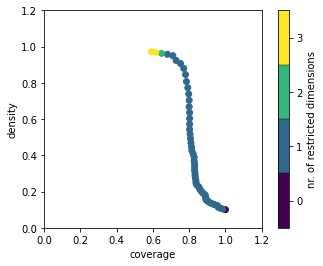

In [7]:
# Show the peeling graph for this prim analysis
box1.show_tradeoff()
plt.show()

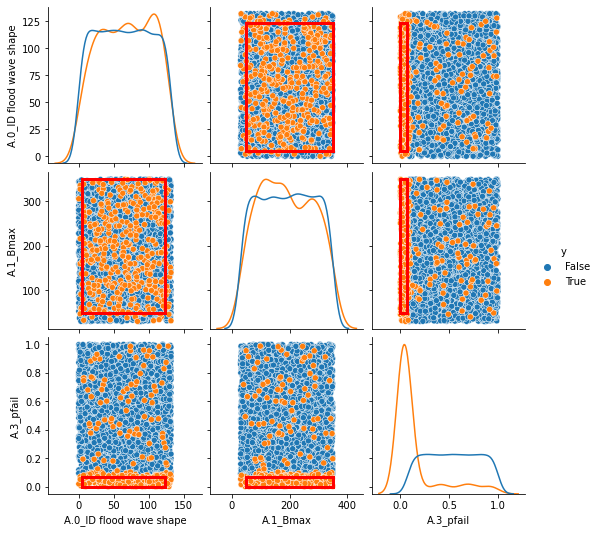

In [8]:
# Show scatter plots for this prim analysis
box1.show_pairs_scatter()
plt.show()


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


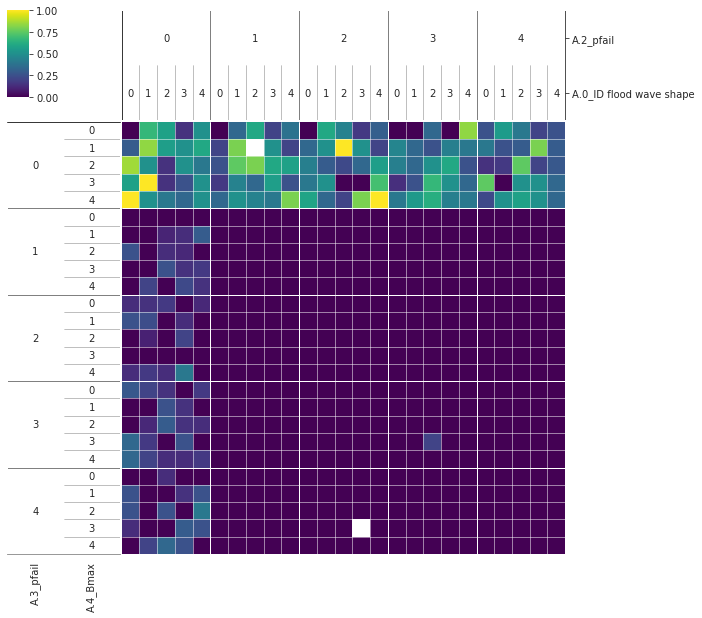

In [9]:
# Do dimensional stacking of results
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(x, y, 2, nbins=5)
plt.show()

## b. Aggregate Gelderland dike rings together for Problem Formulation 3

In [2]:
#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3)

from ema_workbench import load_results

# Load results that were previously generated
load_file_name ='results/4000 scenarios 1 policy PF3.tar.gz'
results = load_results(load_file_name)

# See what the results look like and what outcomes were captured
experiments, outcomes = results
print(outcomes.keys())

# Create temporary dataframe containing experiments and outcomes
temp = experiments.copy(deep=True)
# outcomes
temp.head()

[MainProcess/INFO] results loaded successfully from c:\Users\Gerdus van der Laars\Documents\Q4\EPA 1361\project\final assignment\4000 scenarios 1 policy PF3.tar.gz


dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,129,306.195122,10.0,0.962983,53.124220,1.0,0.398258,287.905419,10.0,0.932412,...,4,9,4,10,0,0,0,1,0,dikesnet
1,41,44.048041,1.5,0.416721,280.200547,10.0,0.428928,313.782776,1.5,0.063094,...,4,9,4,10,0,0,0,2,0,dikesnet
2,94,134.337340,10.0,0.195215,137.719874,1.5,0.775096,92.688888,1.5,0.034488,...,4,9,4,10,0,0,0,3,0,dikesnet
3,54,260.005233,1.0,0.950507,61.399279,1.5,0.359478,234.456442,10.0,0.204367,...,4,9,4,10,0,0,0,4,0,dikesnet
4,31,148.357643,1.5,0.555221,224.399717,10.0,0.666518,70.894212,10.0,0.466214,...,4,9,4,10,0,0,0,5,0,dikesnet


In [3]:
# Aggregate costs and deaths for only the dike rings in Gelderland based on problem formulation 3.


if (load_file_name == 'results/4000 scenarios 1 policy PF3.tar.gz' or load_file_name == "results/1 scenarios 256 policy PF3 SA lever.tar.gz" ):
    n_scen = len(outcomes['A.1 Total Costs'])
    # Dictionary used to hold our newly aggregated outcomes
    agg_outcomes = {}
    # Aggregate all the costs for the three Gelderland dike rings
    arr_costs = [0]*n_scen
    # Aggregate all the deaths for the three Gelderland dike rings
    arr_deaths = [0]*n_scen

    # Go through all the generated scenarios' outcomes and aggregate over the three dike rings of importance
    for i in range(n_scen):
        arr_costs[i] = outcomes['A.1 Total Costs'][i] + outcomes['A.2 Total Costs'][i] + outcomes['A.3 Total Costs'][i]
        arr_deaths[i] = outcomes['A.1_Expected Number of Deaths'][i] + outcomes['A.2_Expected Number of Deaths'][i] + outcomes['A.3_Expected Number of Deaths'][i]

    agg_outcomes['Expected Annual Damage'] = arr_costs
    agg_outcomes['Expected Number of Deaths'] = arr_deaths


In [4]:
experiments = temp.copy(deep=True)

# Drop the lever columns from the dataframe to make sure prim only focusses on uncertainties
experiments.drop(experiments.columns[19:], axis=1, inplace=True)

experiments


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,129,306.195122,10.0,0.962983,53.124220,1.0,0.398258,287.905419,10.0,0.932412,88.000893,1.0,0.265117,86.950134,1.0,0.354406,1.5,3.5,4.5
1,41,44.048041,1.5,0.416721,280.200547,10.0,0.428928,313.782776,1.5,0.063094,293.633142,10.0,0.890807,346.796286,1.5,0.061460,1.5,3.5,1.5
2,94,134.337340,10.0,0.195215,137.719874,1.5,0.775096,92.688888,1.5,0.034488,307.554927,10.0,0.654384,216.517698,1.5,0.572568,4.5,2.5,1.5
3,54,260.005233,1.0,0.950507,61.399279,1.5,0.359478,234.456442,10.0,0.204367,269.772051,1.5,0.719628,230.338687,10.0,0.029680,4.5,4.5,2.5
4,31,148.357643,1.5,0.555221,224.399717,10.0,0.666518,70.894212,10.0,0.466214,211.359187,10.0,0.613050,347.859345,1.5,0.875808,1.5,2.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,83,88.611099,1.0,0.915639,253.767212,1.5,0.412528,47.649914,1.5,0.921686,115.974675,1.0,0.346581,130.958530,1.0,0.847833,3.5,3.5,2.5
3996,44,108.115904,1.5,0.158217,111.737753,1.5,0.097163,137.235023,10.0,0.125045,91.947001,10.0,0.775745,56.823242,1.0,0.461825,1.5,1.5,2.5
3997,48,131.765727,1.0,0.553865,236.022401,1.5,0.918946,191.744811,1.5,0.742084,93.382395,1.0,0.189293,190.109433,1.5,0.372428,1.5,1.5,2.5
3998,8,338.614544,1.5,0.317207,90.737580,10.0,0.200795,209.122544,1.0,0.581187,313.393723,1.0,0.559654,63.169864,1.5,0.376807,2.5,1.5,3.5


## c. Analysis with PRIM

In [5]:
# Prepare to do prim
from ema_workbench.analysis import prim

# Set the output to the category that we are interested in for this run
outcome_entry = agg_outcomes["Expected Annual Damage"]

x = experiments
# Set our output threshold to be the 90th percentile of all of those outputs
y_limit = np.quantile(outcome_entry, 0.9)

# Only select outputs that are above this threshold
y = np.array([value > y_limit for value in outcome_entry])

# Conduct our prim analysis using a threshold of 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)

# Get the box that prim found for us
box1 = prim_alg.find_box()

[MainProcess/INFO] 4000 points remaining, containing 399 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.071, coverage: 0.7117794486215538, density: 1.0 restricted_dimensions: 1


In [24]:
# Prepare to export the box and its scenarios and outcomes for later use in robustness analysis
from ema_workbench import save_results
box_scenarios = experiments.iloc[box1.yi]

box_outcomes = {k:v[box1.yi] for k,v in outcomes.items()}

save_results((box_scenarios, box_outcomes), 'results/scens_expected_deaths.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\Gerdus van der Laars\Documents\Q4\EPA 1361\project\final assignment\scens_expected_deaths.tar.gz


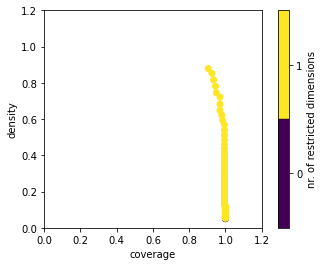

In [25]:
# Show the peeling graph for this prim analysis
box1.show_tradeoff()
plt.show()

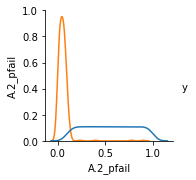

In [16]:
# Show scatter plots for this prim analysis
box1.show_pairs_scatter()
plt.show()


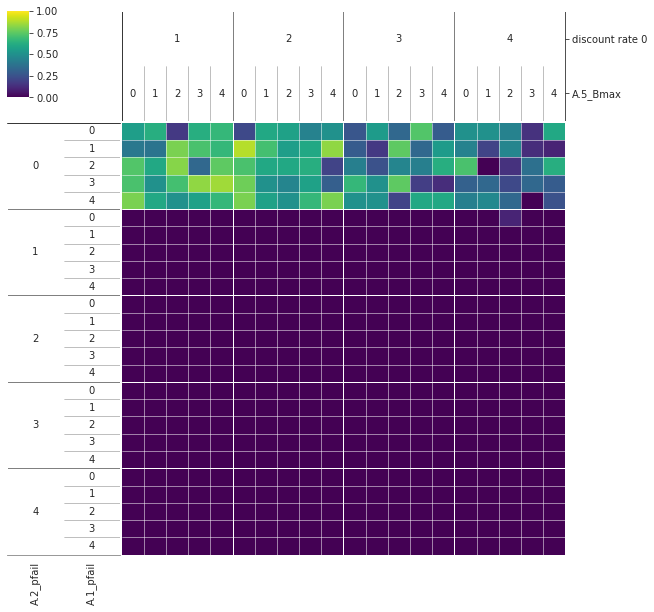

In [6]:
# Do dimensional stacking of results
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(x, y, 2, nbins=5)
plt.show()

# 2. Global Sensitivity Analysis
## a. Sample generation over uncertainty and lever spaces respectively, using SOBOL

In [19]:
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
#running the model through EMA workbench
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments, SequentialEvaluator)
from problem_formulation import get_model_for_problem_formulation
# from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench import Policy, Scenario

# Create a null policy where no action is taken
policies = [Policy('policy 1', **{'0_RfR 0':0,
                                  '0_RfR 1':0,
                                  '0_RfR 2':0,
                                  'A.1_DikeIncrease 0':0,
                                  'A.2_DikeIncrease 0':0,
                                  'A.3_DikeIncrease 0':0,
                                  'A.4_DikeIncrease 0':0,
                                  'A.5_DikeIncrease 0':0,
                                  'A.1_DikeIncrease 1':0,
                                  'A.2_DikeIncrease 1':0,
                                  'A.3_DikeIncrease 1':0,
                                  'A.4_DikeIncrease 1':0,
                                  'A.5_DikeIncrease 1':0,
                                  'A.1_DikeIncrease 2':0,
                                  'A.2_DikeIncrease 2':0,
                                  'A.3_DikeIncrease 2':0,
                                  'A.4_DikeIncrease 2':0,
                                  'A.5_DikeIncrease 2':0,
                                  'EWS_DaysToThreat':0})
                                  ]

# Define a reference scenario with each uncertainty containing the mean value of its range
scenarios = [Scenario('scenario 1', **{'discount rate 0':3,
                                        'discount rate 1':3,
                                        'discount rate 2':3,
                                        'A.1_Bmax':190,
                                        'A.1_Brate':1.5,
                                        'A.1_pfail':0.5,
                                        'A.2_Bmax':190,
                                        'A.2_Brate':1.5,
                                        'A.2_pfail':0.5,
                                        'A.3_Bmax':190,
                                        'A.3_Brate':1.5,
                                        'A.3_pfail':0.5,
                                        'A.4_Bmax':190,
                                        'A.4_Brate':1.5,
                                        'A.4_pfail':0.5,
                                        'A.5_Bmax':190,
                                        'A.5_Brate':1.5,
                                        'A.5_pfail':0.5,
                                        'A.0_ID flood wave shape':66})
                                    ]

ema_logging.log_to_stderr(ema_logging.INFO)

# Use problem formulation 3 (disaggregated dike rings)
dike_model, planning_steps = get_model_for_problem_formulation(3)


# Perform experiments using SOBOL sampling, in this case used for the levers.
with MultiprocessingEvaluator(dike_model) as evaluator:
    sa_results = evaluator.perform_experiments(
        scenarios=scenarios, policies=256, lever_sampling=Samplers.SOBOL
    )

# Save results from the global sensitivity analysis
from ema_workbench import save_results
save_results(sa_results, 'results/1 scenarios 256 policy PF3 SA lever.tar.gz')

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1 scenarios * 16384 policies * 1 model(s) = 16384 experiments
  1%|▎                                   | 127/16384 [00:52<1:22:04,  3.30it/s]

In [12]:
# Load results from the global sensitivity analysis
from ema_workbench import load_results
load_file_name = 'results/1 scenarios 256 policy PF3 SA lever.tar.gz'
sa_results = load_results(load_file_name)

[MainProcess/INFO] results loaded successfully from c:\Users\Gerdus van der Laars\Documents\Q4\EPA 1361\project\final assignment\1 scenarios 256 policy PF3 SA lever.tar.gz


In [15]:
print(outcomes.keys())

dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


In [18]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# Convert our problem to SALib format using EMA's builtin function
experiments, outcomes = sa_results
problem = get_SALib_problem(dike_model.levers)

# Using the outputs and samples generated with SOBOL, do the actual global sensitivity analysis (based on variations)
Si = sobol.analyze(
    problem, outcomes["A.1_Expected Number of Deaths"], calc_second_order=True, print_to_console=False
)

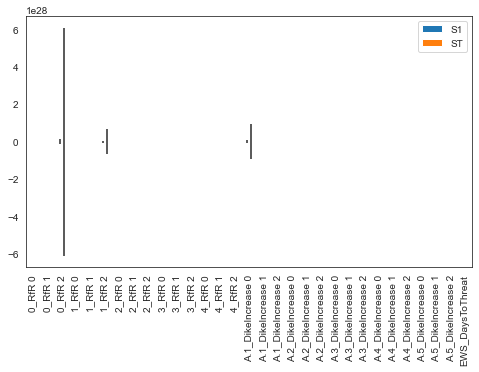

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Plot distributions of ST and ST1 of the values
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## b. Feature scoring

[MainProcess/INFO] results loaded successfully from c:\Users\Gerdus van der Laars\Documents\Q4\EPA 1361\project\final assignment\1 scenarios 256 policy PF3 SA lever.tar.gz
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis b

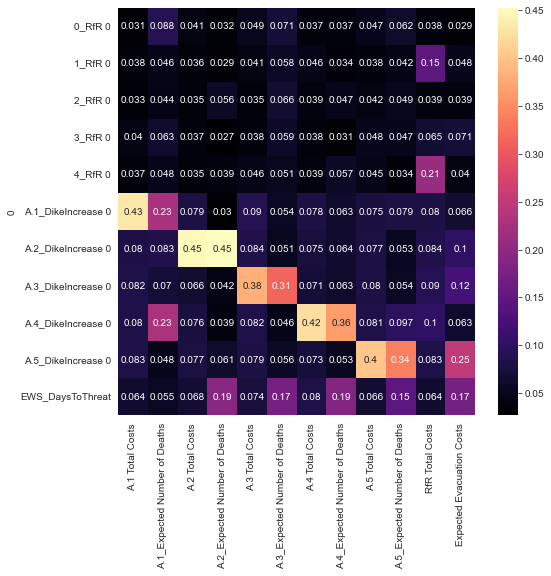

In [20]:
from ema_workbench.analysis import feature_scoring
from ema_workbench import load_results

plt.rcParams["figure.figsize"] = (8,7.5)

# load_file_name = '2000 scenarios 1 policy PF3.tar.gz'
load_file_name ='results/1 scenarios 256 policy PF3 SA lever.tar.gz'
results = load_results(load_file_name)

experiments, outcomes = results

# Drop levers for other time steps to make graph more compact and readable
experiments.drop(experiments.columns[:19], axis=1, inplace=True)
experiments.drop(columns=["0_RfR 1", "0_RfR 2", "1_RfR 1", "1_RfR 2", "2_RfR 1", "2_RfR 2", "3_RfR 1", "3_RfR 2",
                            "4_RfR 1", "4_RfR 2", "A.1_DikeIncrease 1", "A.1_DikeIncrease 2", "A.2_DikeIncrease 1", "A.2_DikeIncrease 2",
                            "A.3_DikeIncrease 1", "A.3_DikeIncrease 2", "A.4_DikeIncrease 1", "A.4_DikeIncrease 2", "A.5_DikeIncrease 1",
                            "A.5_DikeIncrease 2", "policy"], inplace=True)

x = experiments
y = outcomes

# Get feature scores for the SOBOL sampled inputs and their corresponding outputs
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="magma", annot=True)
plt.show()